# RIEML DCC MODEL
> Created July. 2025 <br>
> Nikhil Bisht<br>

# Definitions

In [1]:
# standard system modules
import os, sys
import h5py 
import argparse
# standard module for tabular data
import pandas as pd
import json

# standard module for array manipulation
import numpy as np
from itertools import permutations

# standard statistical module
import scipy.stats as st
from scipy import linalg
from scipy.stats import ks_2samp
import skimage as ski

# standard module for high-quality plots
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# to plot pixelized images
import imageio.v3 as im

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image

from tqdm import tqdm
import random
import time
import plot

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

DATAFILE  = '/data/cb1/nbisht/anvil_scratch/projects/rieml/tubes_take6.h5'
MODELFILE = 'nnmodel.dict'

TEST_PERCENTAGE = 0.2

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}')

idd = 292
what = "291 (proper unet) with more channels and training.  Add dilation"



Available device: cpu 


# Functions

In [26]:
def init_weights_constant(m):
    if isinstance(m, nn.Linear):
        #nn.init.constant_(m.weight, 0.5)
        nn.init.constant_(m.bias, 0.1)

def thisnet():
    hidden_dims = 512,512   
    conv_channels = 16
    model = main_net(base_channels=conv_channels)
    return model

def train(model,data,parameters, validatedata, validateparams):
    epochs = 50000
    lr = 1e-4
    batch_size=3
    weight_decay = 0.01
    trainer(model,data,parameters,validatedata,validateparams,epochs=epochs,lr=lr,batch_size=batch_size, weight_decay = weight_decay)

def trainer(model, data,parameters, validatedata,validateparams,epochs=1, lr=1e-3, batch_size=10, test_num=0, weight_decay=None):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=[25000, 35000,45000],  # change after N and N+M steps
        gamma=0.1             # multiply by gamma each time
    )
    a = torch.arange(len(data))
    N = len(data)
    seed = 8675309
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


    t0 = time.time()
    minlist=[];meanlist=[];maxlist=[];stdlist=[]
    for epoch in range(epochs):
        subset = torch.tensor(random.sample(list(a),batch_size))
        data_subset =  data[subset]
        param_subset = parameters[subset]
        optimizer.zero_grad()
        output1=model(param_subset)
        loss = model.criterion(output1, data_subset[:,1,:,:], initial=data_subset[:,0,:,:])
        loss.backward()
        optimizer.step()
        scheduler.step()
        tnow = time.time()
        tel = tnow-t0
        if (epoch>0 and epoch%100==0) or epoch==10:
            model.eval()
            validate_losses = plot.compute_losses(model, validatedata, validateparams)
            model.train()

            time_per_epoch = tel/epoch
            epoch_remaining = epochs-epoch
            time_remaining_s = time_per_epoch*epoch_remaining
            hrs = time_remaining_s//3600
            minute = (time_remaining_s-hrs*3600)//60
            sec = (time_remaining_s - hrs*3600-minute*60)#//60
            time_remaining="%02d:%02d:%02d"%(hrs,minute,sec)

            mean = validate_losses.mean()
            std = validate_losses.std()
            mmin = validate_losses.min()
            mmax = validate_losses.max()
            minlist.append(mmin)
            maxlist.append(mmax)
            meanlist.append(mean)
            stdlist.append(std)
            if epoch%5000==0:
                print("test%d Epoch %d loss %0.2e LR %0.2e time left %8s loss mean %0.2e var %0.2e min %0.2e max %0.2e"%
                      (idd,epoch,loss, optimizer.param_groups[0]['lr'], time_remaining, mean, std, mmin, mmax))
            loss_batch=[]
    print("Run time", tel)
    plt.clf()
    plt.plot(meanlist,c='k')
    plt.plot(np.array(meanlist)+np.array(stdlist),c='b')
    plt.plot(np.array(meanlist)-np.array(stdlist),c='b')
    plt.plot(minlist,c='r')
    plt.plot(maxlist,c='r')
    plt.yscale('log')
    plt.savefig('./plots/errortime_test%d'%(idd))
    plt.clf()

class main_net(nn.Module):
    def __init__(self, output_length=1000, base_channels=16):
        super().__init__()
        self.output_length = output_length

        # Project global 7D input → pseudo-spatial representation
        self.fc1 = nn.Linear(7, 3 * output_length)
        self.relu1 = nn.ReLU()

        # Encoder (Downsampling path)
        self.enc1 = ConvBlock(3, base_channels)            # L
        self.enc2 = ConvBlock(base_channels, base_channels*2)  # L/2
        self.enc3 = ConvBlock(base_channels*2, base_channels*4) # L/4

        # Bottleneck
        #self.bottleneck = ConvBlock(base_channels*4, base_channels*8)
        self.bottleneck = DilatedBlock(base_channels*4, base_channels*8, dilations=[1, 2, 4, 8])


        # Decoder (Upsampling path)
        self.up3 = UpBlock(base_channels*8, base_channels*4)
        self.up2 = UpBlock(base_channels*4, base_channels*2)
        self.up1 = UpBlock(base_channels*2, base_channels)

        # Output projection
        self.out_conv = nn.Conv1d(base_channels, 3, kernel_size=1)

        # Loss functions
        self.l1 = nn.L1Loss()
        self.mse = nn.MSELoss()
        self.huber = nn.HuberLoss(delta=0.2)

        # Weight initialization
        self.apply(self.init_weights)

    @staticmethod
    def init_weights_kamming(m):
        if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    @staticmethod
    def init_weights(m):
        if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d, nn.Linear)):
            nn.init.constant_(m.bias, 0.1)

    def criterion(self, guess, target, initial=None):
        L1 = self.l1(guess, target)
        return L1

    def forward(self, x):
        batch_size = x.shape[0]

        # Project global → spatial
        x = self.fc1(x)
        x = self.relu1(x)
        x = x.view(batch_size, 3, self.output_length)

        # Encoder
        e1 = self.enc1(x)                # (B, C, L)
        e2 = self.enc2(F.avg_pool1d(e1, 2))  # (B, 2C, L/2)
        e3 = self.enc3(F.avg_pool1d(e2, 2))  # (B, 4C, L/4)

        # Bottleneck
        b = self.bottleneck(F.avg_pool1d(e3, 2))  # (B, 8C, L/8)

        # Decoder
        d3 = self.up3(b, e3)             # (B, 4C, L/4)
        d2 = self.up2(d3, e2)           # (B, 2C, L/2)
        d1 = self.up1(d2, e1)           # (B, C, L)

        # Final output
        out = self.out_conv(d1)         # (B, 3, L)

        return out


class ConvBlock(nn.Module):
    """
    Two-layer convolutional block with ReLU
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)


class UpBlock(nn.Module):
    """
    Upsampling block with skip connection
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.conv = ConvBlock(in_channels=out_channels*2, out_channels=out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        # If needed, crop skip to match x
        if x.shape[-1] != skip.shape[-1]:
            diff = skip.shape[-1] - x.shape[-1]
            skip = skip[..., :x.shape[-1]]
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)
class DilatedBlock(nn.Module):
    """
    Stack of dilated convolutions with increasing dilation rates.
    """
    def __init__(self, in_channels, out_channels, dilations):
        super().__init__()
        layers = []
        for d in dilations:
            layers.append(
                nn.Conv1d(
                    in_channels,
                    out_channels,
                    kernel_size=3,
                    padding=d,
                    dilation=d
                )
            )
            layers.append(nn.ReLU())
            in_channels = out_channels  # for next layer
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


# Visualize Model

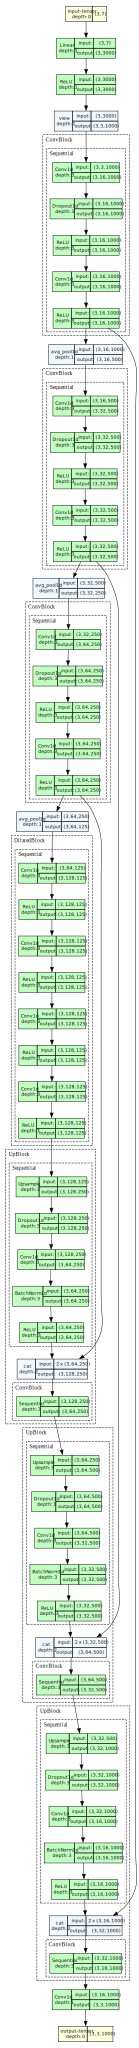

In [21]:
from torchview import draw_graph

model = thisnet()
batch_size = 3
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model, input_size=(batch_size,7), device='meta', expand_nested=True, depth=3)
model_graph.visual_graph

# Load Images

In [22]:
from importlib import reload
import plot
reload(plot)

import tube_loader

testnum=idd
#data = tube_loader.load_many()
if 'rieml_data' not in dir():
    rieml_data, parameters= tube_loader.read_good_parameters(DATAFILE, nvalid=50, ntest=100)


# Train Model

test292 Epoch 5000 loss 2.99e-01 LR 1.00e-04 time left 00:15:39 loss mean 2.33e-01 var 7.47e-02 min 1.17e-01 max 5.10e-01
test292 Epoch 10000 loss 1.10e-01 LR 1.00e-04 time left 00:13:23 loss mean 1.34e-01 var 2.78e-02 min 8.66e-02 max 1.98e-01
test292 Epoch 15000 loss 7.62e-02 LR 1.00e-04 time left 00:11:53 loss mean 9.99e-02 var 1.54e-02 min 8.06e-02 max 1.35e-01
test292 Epoch 20000 loss 7.61e-02 LR 1.00e-04 time left 00:10:07 loss mean 1.10e-01 var 1.74e-02 min 8.41e-02 max 1.61e-01
test292 Epoch 25000 loss 7.47e-02 LR 1.00e-05 time left 00:08:31 loss mean 1.04e-01 var 1.66e-02 min 7.24e-02 max 1.50e-01
test292 Epoch 30000 loss 8.32e-02 LR 1.00e-05 time left 00:06:49 loss mean 4.49e-02 var 1.62e-02 min 2.77e-02 max 9.16e-02
test292 Epoch 35000 loss 3.49e-02 LR 1.00e-06 time left 00:05:08 loss mean 4.12e-02 var 1.64e-02 min 2.34e-02 max 8.76e-02
test292 Epoch 40000 loss 3.08e-02 LR 1.00e-06 time left 00:03:25 loss mean 4.26e-02 var 1.61e-02 min 2.35e-02 max 9.59e-02
test292 Epoch 450

/home/nbisht/nikhil_20241011/lib/python3.12/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([3, 1000])) that is different to the input size (torch.Size([1, 3, 1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


./plots/rieML_test292_test_best_0000
./plots/rieML_test292_test_best_0001
./plots/rieML_test292_test_best_0002
./plots/rieML_test292_test_best_0003
./plots/rieML_test292_test_best_0004
./plots/rieML_test292_test_worst_0000
./plots/rieML_test292_test_worst_0001
./plots/rieML_test292_test_worst_0002
./plots/rieML_test292_test_worst_0003
./plots/rieML_test292_test_worst_0004
./plots/rieML_test292_train_best_0000
./plots/rieML_test292_train_best_0001
./plots/rieML_test292_train_best_0002
./plots/rieML_test292_train_best_0003
./plots/rieML_test292_train_best_0004
./plots/rieML_test292_train_worst_0000
./plots/rieML_test292_train_worst_0001
./plots/rieML_test292_train_worst_0002
./plots/rieML_test292_train_worst_0003
./plots/rieML_test292_train_worst_0004
./plots/rieML_test0292_avalidate_0000
./plots/rieML_test0292_avalidate_0001
./plots/rieML_test0292_avalidate_0002
./plots/rieML_test0292_avalidate_0003
./plots/rieML_test0292_avalidate_0004
./plots/rieML_test0292_avalidate_0005
./plots/rieM

<Figure size 640x480 with 0 Axes>

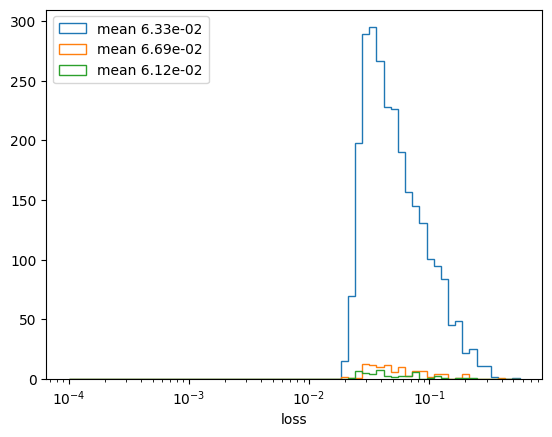

In [27]:
new_model = 1
load_model = 0
train_model = 1

if new_model:
    model = thisnet()

if load_model:
    model.load_state_dict(torch.load("models/test%d.pth"%idd))

total_time='no'
if train_model:
    t0 = time.time()

    train(model,rieml_data['train'],parameters['train'], rieml_data['validate'],parameters['validate'])

    t1 = time.time() - t0
    hrs = t1//3600
    minute = (t1-hrs*3600)//60
    sec = (t1 - hrs*3600-minute*60)#//60
    total_time="%02d:%02d:%02d"%(hrs,minute,sec)

if 1:
    print('losses')
    loss_train = plot.compute_losses(model, rieml_data['train'],parameters['train'])
    loss_test = plot.compute_losses(model, rieml_data['test'],parameters['test'])
    loss_validate = plot.compute_losses(model, rieml_data['validate'],parameters['validate'])
    args_train = torch.argsort(loss_train)
    args_test = torch.argsort(loss_test)
    #args_validate = torch.argsort(loss_validate)
if 1:
    print('plot')
    plot.plot_hist(loss_train,loss_test,loss_validate,idd)

    zzz=plot.test_plot(rieml_data['test'][args_test[:5]], parameters['test'][args_test[:5]], model, fname="test%d_test_best"%testnum)
    zzz=plot.test_plot(rieml_data['test'][args_test[-5:]], parameters['test'][args_test[-5:]], model, fname="test%d_test_worst"%testnum)
    zzz=plot.test_plot(rieml_data['train'][args_train[:5]], parameters['train'][args_train[:5]], model, fname="test%d_train_best"%testnum)
    zzz=plot.test_plot(rieml_data['train'][args_train[-5:]], parameters['train'][args_train[-5:]], model, fname="test%d_train_worst"%testnum)
    zzz=plot.test_plot(rieml_data['validate'], parameters['validate'], model, fname="test%04d_avalidate"%testnum)

if not load_model:
    nparam = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model test{testnum:d} with {nparam:,d} parameters elapsed {total_time:s}")
    oname = "models/test%d.pth"%testnum
    torch.save(model.state_dict(), oname)
    print("model saved ",oname)

# Documentation for different metrics
[scikit-image documentation](https://scikit-image.org/docs/0.25.x/api/skimage.metrics.html#module-skimage.metrics)

In [23]:
def plot_comparison(input_arr, pred_output_arr, act_output_arr, label, save_filename='xy_data.png', dont_show = False):
    input_str = 'INPUT IMAGE:\n'
    pred_str = 'PREDICTED IMAGE:\n'
    act_str = 'ACTUAL IMAGE:\n'
    # Calculate metrics
    input_MSE = ski.metrics.mean_squared_error(act_output_arr, input_arr)
    input_str+= 'MSE: '+'{:0.5f}'.format(input_MSE)+'\n'
    pred_MSE = ski.metrics.mean_squared_error(act_output_arr, pred_output_arr)
    pred_str+= 'MSE: '+'{:0.5f}'.format(pred_MSE)+'\n'
    actual_MSE = ski.metrics.mean_squared_error(act_output_arr, act_output_arr)
    act_str+= 'MSE: '+'{:0.5f}'.format(actual_MSE)+'\n'

    input_NMI = ski.metrics.normalized_mutual_information(act_output_arr, input_arr, bins=100)
    input_str+= 'NMI: '+'{:0.5f}'.format(input_NMI)+'\n'
    pred_NMI = ski.metrics.normalized_mutual_information(act_output_arr, pred_output_arr, bins=100)
    pred_str+= 'NMI: '+'{:0.5f}'.format(pred_NMI)+'\n'
    actual_NMI = ski.metrics.normalized_mutual_information(act_output_arr, act_output_arr, bins=100)
    act_str+= 'NMI: '+'{:0.5f}'.format(actual_NMI)+'\n'

    inversed_input_arr = img_inverse_transform(input_arr)
    inversed_pred_output_arr = img_inverse_transform(pred_output_arr)
    inversed_act_output_arr = img_inverse_transform(act_output_arr)
    input_PSNR = ski.metrics.peak_signal_noise_ratio(inversed_act_output_arr, inversed_input_arr, data_range=np.max(inversed_input_arr) - np.min(inversed_input_arr))
    input_str+= 'PSNR: '+'{:0.5f}'.format(input_PSNR)+'\n'
    pred_PSNR = ski.metrics.peak_signal_noise_ratio(inversed_act_output_arr, inversed_pred_output_arr, data_range=np.max(inversed_pred_output_arr) - np.min(inversed_pred_output_arr))
    pred_str+= 'PSNR: '+'{:0.5f}'.format(pred_PSNR)+'\n'
    actual_PSNR = ski.metrics.peak_signal_noise_ratio(inversed_act_output_arr, inversed_act_output_arr, data_range=np.max(inversed_act_output_arr) - np.min(inversed_act_output_arr))
    act_str+= 'PSNR: '+'{:0.5f}'.format(actual_PSNR)+'\n'

    input_SSI = ski.metrics.structural_similarity(act_output_arr, input_arr, gradient=False, data_range=np.max(input_arr) - np.min(input_arr), channel_axis=None)
    input_str+= 'SSI: '+'{:0.5f}'.format(input_SSI)+'\n'
    pred_SSI = ski.metrics.structural_similarity(act_output_arr, pred_output_arr, gradient=False, data_range=np.max(pred_output_arr) - np.min(pred_output_arr), channel_axis=None)
    pred_str+= 'SSI: '+'{:0.5f}'.format(pred_SSI)+'\n'
    actual_SSI = ski.metrics.structural_similarity(act_output_arr, act_output_arr, gradient=False, data_range=np.max(act_output_arr) - np.min(act_output_arr), channel_axis=None)
    act_str+= 'SSI: '+'{:0.5f}'.format(actual_SSI)+'\n'

    input_total_density = np.sum(inversed_input_arr)
    input_str+= 'Total Density: '+'{:0.5f}'.format(input_total_density)+'\n'
    pred_total_density = np.sum(inversed_pred_output_arr)
    pred_str+= 'Total Density: '+'{:0.5f}'.format(pred_total_density)+'\n'
    act_total_density = np.sum(inversed_act_output_arr)
    act_str+= 'Total Density: '+'{:0.5f}'.format(act_total_density)+'\n'

    fig = plt.figure(figsize=(12, 12))
    
    for i in range(3):
        ax  = fig.add_subplot(3, 3, 3*i+1)
        c = ax.pcolormesh(np.mean(input_arr, axis=i).T)
        fig.colorbar(c, ax=ax)
        if i==0:
            ax.set_title('Input: '+str(label[0])+'_'+str(label[1])+'_'+str(label[2]))
        ax.grid('both')
        if i==2:
            ax.text(0.15, -0.02, input_str, fontsize=10, transform=plt.gcf().transFigure, bbox=dict(boxstyle="round", edgecolor='black', facecolor='white'))

    for i in range(3):
        ax2  = fig.add_subplot(3, 3, 3*i+2)
        c = ax2.pcolormesh(np.mean(pred_output_arr, axis=i).T)
        fig.colorbar(c, ax=ax2)
        if i==0:
            ax2.set_title('Predicted Output '+str(label[0])+'_'+str(label[1])+'_'+str(label[2]))
        ax2.grid('both')
        if i==2:
            ax2.text(0.4, -0.02, pred_str, fontsize=10, transform=plt.gcf().transFigure, bbox=dict(boxstyle="round", edgecolor='black', facecolor='white'))

    for i in range(3):
        ax3  = fig.add_subplot(3, 3, 3*i+3)
        c = ax3.pcolormesh(np.mean(act_output_arr, axis=i).T)
        fig.colorbar(c, ax=ax3)
        if i==0:
            ax3.set_title('Actual Output '+str(label[0])+'_'+str(label[1])+'_'+str(label[2]))
        ax3.grid('both')
        if i==2:
            ax3.text(0.7, -0.02, act_str, fontsize=10, transform=plt.gcf().transFigure, bbox=dict(boxstyle="round", edgecolor='black', facecolor='white'))


    if save_filename:
        plt.savefig(save_filename, bbox_inches='tight')
    
    if dont_show==False:
        plt.show()
    plt.close()

def compare_output(input_arr, output_arr, labels, args):
    # Load the trained model
    model = UNet3D(in_channels=1, out_channels=1).to(DEVICE)
    model.load_state_dict(torch.load(args.run_name+'_'+args.loss_type+'_'+MODELFILE))
    model.eval()

    with torch.no_grad():
        for i in range(len(input_arr)):
            inputs = input_arr[i].unsqueeze(0).unsqueeze(0)
            targets = output_arr[i].unsqueeze(0).unsqueeze(0)
            label = labels[i]
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            # Save the output images
            output_image = outputs.cpu().numpy()
            plot_comparison(inputs[0][0].numpy(), output_image[0][0], targets[0][0].numpy(), label, save_filename='./3D_test_plots/img'+"_".join(str(x) for x in label)+'.png', dont_show = True)
    print("Testing completed and output images plotted.")

compare_output(input_image_test, output_image_test, label_test, args)

/tmp/ipykernel_1529524/1535411040.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(args.run_name+'_'+args.loss_type+'_'+MODELFILE))
/hom

Testing completed and output images plotted.


## Notes

* Add info about what frame or time is being looked at
* look at the Unet structure and draw it out
* Also, is the MSE actually good? what does it represent in terms of value? if initial is set as final, what is the MSE then? as comparison
* add NMI, PSNR, SSI and total density to loss [here's a link](https://medium.com/@baicenxiao/strategies-for-balancing-multiple-loss-functions-in-deep-learning-e1a641e0bcc0)
